# Sentiment Analysis on Game Reviews
## Jessica Erasmus

### Importing libraries

In [1]:
#!pip install imbalanced-learn
#!pip install imblearn
#!pip install wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import FunctionTransformer

from xgboost import XGBClassifier

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.tokenize.mwe import MWETokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet
 
import warnings
warnings.filterwarnings("ignore")

#!pip install spacy
#!python -m spacy download en_core_web_sm
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wavec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wavec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wavec\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wavec\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wavec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading and inspecting dataset 

In [2]:
# Loading dataset
# https://www.kaggle.com/code/hossamelshabory97/popular-video-games-1980-2023-eda/input
df = pd.read_csv("input/games.csv")

In [3]:
# Taking a look at a sample from the dataset
df.sample(2)

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
1146,1146,Overcooked! 2,"Aug 07, 2018","['Ghost Town Games', 'Team17']",3.6,414,414,"['Arcade', 'Indie', 'Simulator', 'Strategy', '...",Overcooked returns with a brand-new helping of...,"['con esto peleamos con luciana', 'I hate my f...",4.9K,227,889,184
468,468,Mass Effect 2,"Jan 26, 2010","['BioWare', 'Electronic Arts']",4.3,1.3K,1.3K,"['Adventure', 'RPG', 'Shooter']",Are you prepared to lose everything to save th...,"[""I'm Commander Shepard and this is my favorit...",9.6K,107,1.9K,645


In [4]:
# View dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB


### Data Cleaning and Preprocessing

In [5]:
# Checking the number of duplicate values
dup_count = df.duplicated().sum()

print(f"There are {dup_count} duplicate values in this dataset.")

There are 0 duplicate values in this dataset.


In [6]:
# Printing the number of null values
null_count = df.isnull().sum()

# Filtering out columns that ONLY has NUll values 
null_count[null_count != 0]

Team        1
Rating     13
Summary     1
dtype: int64

In [7]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    # Use list comprehension to create a new list of column names with spaces replaced by underscores and all lowercase letters
    new_columns = [col.replace("_", " ") for col in df.columns]

    # Use the pandas DataFrame rename() method to rename the columns using the new column names list
    df = df.rename(columns=dict(zip(df.columns, new_columns)))

    return df

def drop_columns(df: pd.DataFrame, cols_to_drop: list = None, 
                 idx_to_drop: list = None) -> pd.DataFrame:
     # Drop the specified columns from the DataFrame
    if cols_to_drop is not None:
        df = df.drop(columns=cols_to_drop)

    # Drop the specified rows from the DataFrame, if any
    if idx_to_drop is not None:
        df = df.drop(index=idx_to_drop)
        
    return df 

def convert_str_num_to_int(df: pd.DataFrame, col_names: list) -> pd.DataFrame: 
    # Looping over the column names list
    for col in col_names:
        # Replace 'K' with '000'
        df[col] = df[col].str.replace("K", "000")

        # Multiply the values by 1000 to handle decimal values correctly
        df[col] = df[col].map(lambda x: int(float(x) * 1000) if '.' in x else int(x))

    return df

In [8]:
# Taking a closer look at the released date column
cond = df["Release Date"] == "releases on TBD"

# Filtering the dataset
df[cond]

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
644,644,Deltarune,releases on TBD,['tobyfox'],4.3,313,313,"['Adventure', 'Indie', 'Music', 'Puzzle', 'RPG']","UNDERTALE's parallel story, DELTARUNE. Meet ne...","['Spamton is so hot, I want to kiss him in the...",1.3K,83,468,617
649,649,Death Stranding 2,releases on TBD,['Kojima Productions'],NaN,105,105,"['Adventure', 'Shooter']",NaN,[],3,0,209,644
1252,1252,Elden Ring: Shadow of the Erdtree,releases on TBD,"['FromSoftware', 'Bandai Namco Entertainment']",4.8,18,18,"['Adventure', 'RPG']",An expansion to Elden Ring setting players on ...,['I really loved that they integrated Family G...,1,0,39,146


In [9]:
# Dropping rows using their index from the bool filter
df = drop_columns(df, idx_to_drop=df[cond].index)

In [10]:
# Changing the `Release Date` Column
df["Release Date"] = pd.to_datetime(df["Release Date"])

# Checking datatype conversion
df["Release Date"].dtype

dtype('<M8[ns]')

In [11]:
# Extract the release year from the release date column
df["Release Year"] = df["Release Date"].dt.year

In [12]:
# Defining the columns to drop
cols_names = ["Unnamed: 0", "Release Date", "Times Listed"]

# Calling the drop columns function
df = drop_columns(df, cols_names)

In [13]:
# Checking the results
df.head()

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Release Year
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K,2022
1,Hades,['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K,2019
2,The Legend of Zelda: Breath of the Wild,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K,2017
3,Undertale,"['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K,2015
4,Hollow Knight,['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K,2017


In [14]:
# Using the `clean_column_names` utility function to rename the columns. 
df = clean_column_names(df)

# Checking the results
df.head()

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist,Release Year
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K,2022
1,Hades,['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K,2019
2,The Legend of Zelda: Breath of the Wild,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K,2017
3,Undertale,"['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K,2015
4,Hollow Knight,['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K,2017


In [15]:
# Defining the rename mapper {old name: new name}
rename_mapper = {"Plays":"Number of Plays", "Playing":"Active Players"}

# Renaming the columns
df.rename(columns=rename_mapper, inplace=True)

# Checking the results
df.head()

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K,2022
1,Hades,['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K,2019
2,The Legend of Zelda: Breath of the Wild,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K,2017
3,Undertale,"['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K,2015
4,Hollow Knight,['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K,2017


In [16]:
# Define the list of columns to unpack the numbers and convert them into int data type.
numerical_cols = ["Number of Reviews", "Number of Plays", "Active Players", "Backlogs", "Wishlist"]

# Using the utility function to handle the string (object) numerical values and unpack the 'K'  symbol to thousands
df = convert_str_num_to_int(df, numerical_cols)

# Checking the results
df.head()

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800,2022
1,Hades,['Supergiant Games'],4.3,2900,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,3200,6300,3600,2019
2,The Legend of Zelda: Breath of the Wild,"['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600,2017
3,Undertale,"['tobyfox', '8-4']",4.2,3500,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,679,4900,1800,2015
4,Hollow Knight,['Team Cherry'],4.4,3000,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,2400,8300,2300,2017


In [17]:
# Checking new data types
df.dtypes

Title                 object
Team                  object
Rating               float64
Number of Reviews      int64
Genres                object
Summary               object
Reviews               object
Number of Plays        int64
Active Players         int64
Backlogs               int64
Wishlist               int64
Release Year           int32
dtype: object

In [18]:
# Drop null values
df.dropna(inplace=True)

In [19]:
# Replace '[', ']', and "'" characters in the teams column
df["Team"] = df["Team"].str.replace('[\[\]\'\"]', "")

# Replace '[', ']', and "'" characters in the genres column
df["Genres"] = df["Genres"].str.replace('[\[\]\'\"]', "")

# Creating a binary matrix of genre values for each game
genres = df["Genres"].str.get_dummies(",")

# Replace '[', ']', and "'" characters in the reviews column
df["Reviews"] = df["Reviews"].str.replace('[\[\]\'\"]', "")

# Creating a binary matrix of reviews values
reviews = df["Reviews"].str.get_dummies(";")

### Exploratory Data Analysis

#### Popularity

In [20]:
# Summing the occurrences of each genre across all games
popularity = genres.sum().sort_values(ascending=False)

# Printing the popularity of each genre
popularity.head()

['Adventure'    962
 'RPG']         245
 'Shooter']     233
 'Indie'        191
 'RPG'          177
dtype: int64

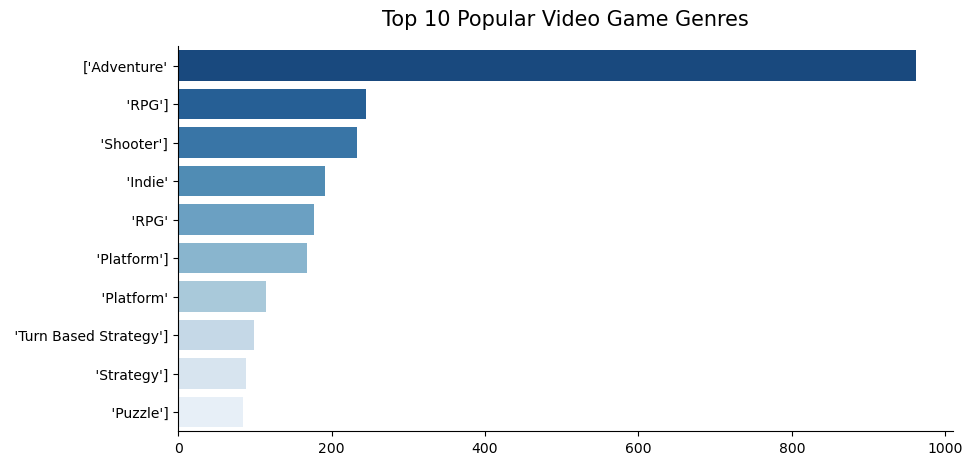

In [21]:
# Set the plot's figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Horizontal bar chart
sns.barplot(x=popularity[:10].values, y=popularity[:10].index, palette="Blues_r", ax=ax)

# Set the title and axis labels
ax.set_title("Top 10 Popular Video Game Genres", fontsize=15, pad=15)
ax.set_xlabel("")
ax.set_ylabel("")

# Removing the spines from the right and top sides of the plot
sns.despine(right=True, top=True)

plt.show()

In [22]:
# Convert the popularity to a new dataframe
popularity_df = popularity.to_frame(name="Popularity")

# Merge the popularity data with the game data
df_pop = df.merge(popularity_df, left_on="Genres", right_index=True)

# Group data by genre
grouped = df_pop.groupby("Genres")

# Define a function to get the most popular game in each group
def get_most_pop_game(group: pd.DataFrame) -> pd.Series:

    # Get the row with the highest popularity value
    most_popular_game = group.loc[group["Popularity"].idxmax()]
    
    # Return the title of the most popular game
    return most_popular_game["Title"]

# Applying the function to the grouped dataframe and saving the result (series) into a variable
most_popular_game = grouped.apply(get_most_pop_game)


In [23]:
# Convert series into a dataframe, reset index and rename columns 
most_popular_game.to_frame().reset_index() \
                 .rename({"Genres":"Game Genre", 0:"Most Popular Game"}, axis=1)

,Game Genre,Most Popular Game
0,['Adventure'],Metal Gear Solid 2: Sons of Liberty
1,['Arcade'],Chrome Dino
2,['Brawler'],Devil May Cry
3,['Card & Board Game'],Mario Party Superstars
4,['Fighting'],MultiVersus
5,['Indie'],Friday the 13th: The Game
6,['MOBA'],Pokémon Unite
7,['Music'],Friday Night Funkin'
8,['Platform'],Super Mario Bros. 3
9,['Puzzle'],Tetris


#### Average Game ratings

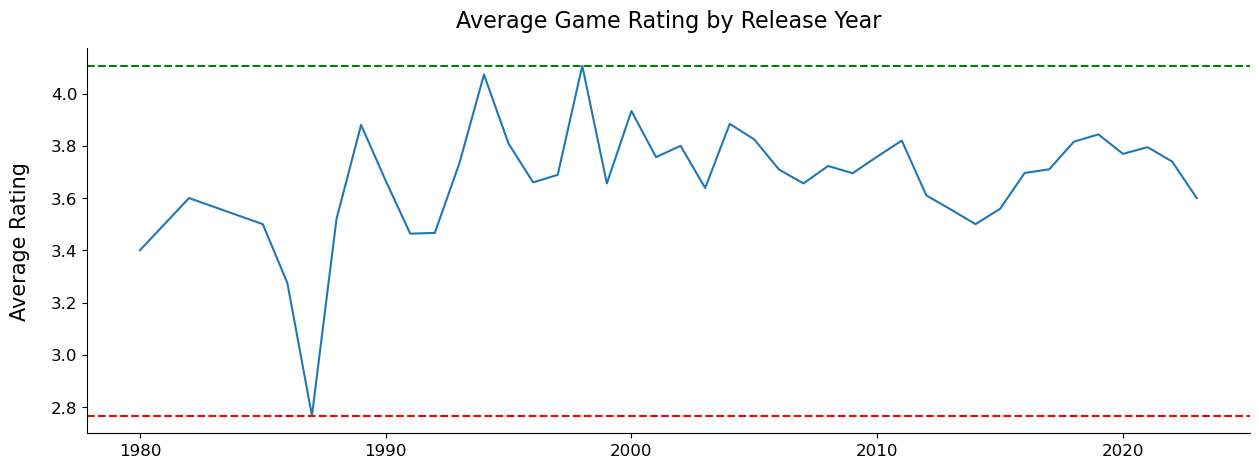

In [24]:
# Group data by release year and calculate the average rating for each year
yearly_avg_rating = df.groupby("Release Year")["Rating"].mean().reset_index()

# Set plot size
plt.figure(figsize=(15, 5))

# Plot the average rating by release year
sns.lineplot(data=yearly_avg_rating, x="Release Year", y="Rating")

# Despine the plot from the top and left
sns.despine(top=True, right=True)

# Add a descriptive title to the plot
plt.title("Average Game Rating by Release Year", fontsize=16, pad=15)

# Increase the padding space between the title, x-label and y-label and the plot
plt.xlabel("")
plt.ylabel("Average Rating", labelpad=15, fontsize=15)

# Increase the font-size of the x-axis and y-axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal lines to indicate maximum and minimum values on the y-axis
plt.axhline(y=yearly_avg_rating["Rating"].max(), color="green", linestyle="--")
plt.axhline(y=yearly_avg_rating["Rating"].min(), color="red", linestyle="--")

plt.show()

#### Game Engagement

In [25]:
# Remove rows with a value of 0 in the active players column
df_engagement = df[df["Active Players"] != 0]

# Calculate the average number of plays per active player for each game
df_engagement["Average Plays per Player"] = round(df_engagement["Number of Plays"] / df_engagement["Active Players"])

# Sortting the data by average number of plays per active player in descending order
df_engagement = df_engagement.sort_values(by="Average Plays per Player", ascending=False)

# Displaying the top 5 games with the highest average number of plays per active player
df_engagement.sample(5)

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year,Average Plays per Player
561,"Flower, Sun, and Rain","['Grasshopper Manufacture', 'Victor Interactiv...",4.3,466,"['Adventure', 'Puzzle']","Flower, Sun and Rain is a PlayStation 2 puzzle...",['i would sell an intestine for a remaster or ...,632,32,1000,1100,2001,20.0
1071,PowerWash Simulator,"['Square Enix', 'FuturLab']",3.7,304,"['Indie', 'Simulator']",Release the Pressure with PowerWash Simulator!...,"[""It's exactly what it sounds like. One of the...",1700,242,255,274,2021,7.0
1197,The Legend of Heroes: Trails of Cold Steel,"['XSEED Games', 'Nihon Falcom']",3.7,499,"['Adventure', 'RPG', 'Turn Based Strategy']",The Legend of Heroes: Trails of Cold Steel is ...,"[""This game takes a long time for everything, ...",2100,129,1000,461,2013,16.0
838,Tunic,"['Andrew Shouldice', 'Finji']",3.9,891,"['Adventure', 'Indie', 'Puzzle', 'RPG']",Tunic is an action adventure about a tiny fox ...,['PEAK. A near flawless game for me and really...,3400,489,2400,2600,2022,7.0
557,Infamous: Second Son,"['Sony Computer Entertainment', 'Sucker Punch ...",3.4,668,"['Adventure', 'Platform', 'Shooter']","Infamous: Second Son, a PlayStation 4 exclusiv...","['bereyi çıkar artık', 'I don’t like delvin or...",7600,71,1300,574,2014,107.0


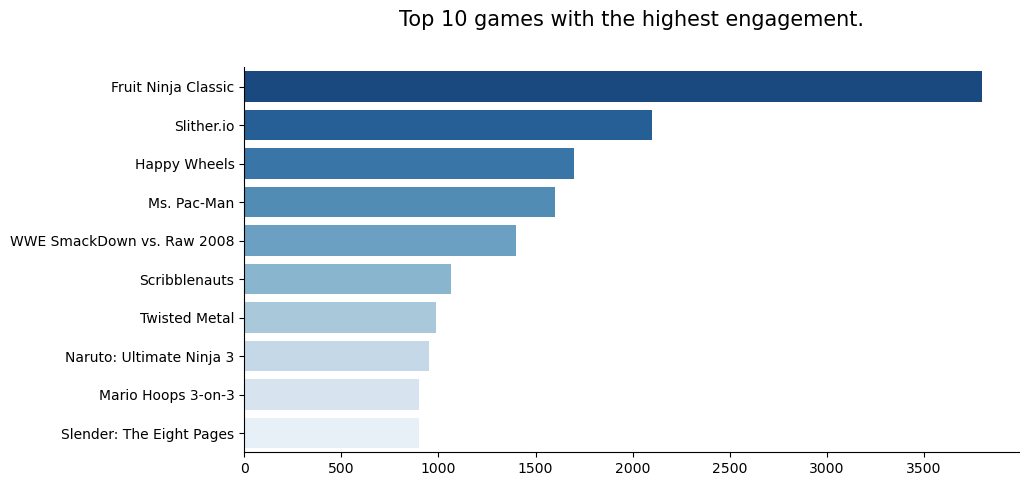

In [26]:
# Set the plot's figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Create a horizontal bar plot showing the average number of plays per active player for the top 10 games
sns.barplot(data=df_engagement.head(10), x="Average Plays per Player", y="Title", palette="Blues_r")

# Set the title and axis labels
ax.set_title("Top 10 games with the highest engagement.", fontsize=15, pad=30)
ax.set_xlabel("")
ax.set_ylabel("")

# Removing spines from the right and top sides of the plot
sns.despine(right=True, top=True)

plt.show()

#### Correlation

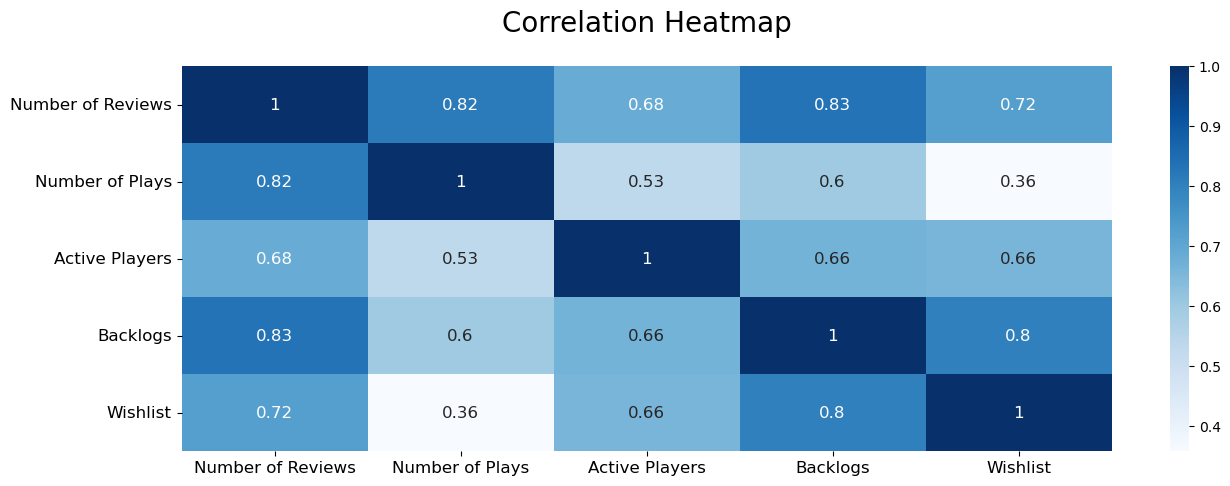

In [27]:
# Calculating the correlation matrix
corr_matrix = df[['Number of Reviews', 'Number of Plays', 'Active Players', 'Backlogs', 'Wishlist']].corr()

# Setting up the figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Creating the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="Blues", annot_kws={"size": 12}, ax=ax)

# Setting up the title
ax.set_title("Correlation Heatmap", fontsize=20, pad=25)

# Setting the x-axis and y-axis ticks sizes
ax.tick_params(axis="both", labelsize=12)

# Showing the plot
plt.show()

In [28]:
# Group  data by the wishlist column and calculate the mean of the backlogs column for each group
wishlist_backlog = df.groupby("Wishlist")["Backlogs"].mean().reset_index()

# Rename the columns for clarity
wishlist_backlog.columns = ["Wishlist", "Average Backlogs"]

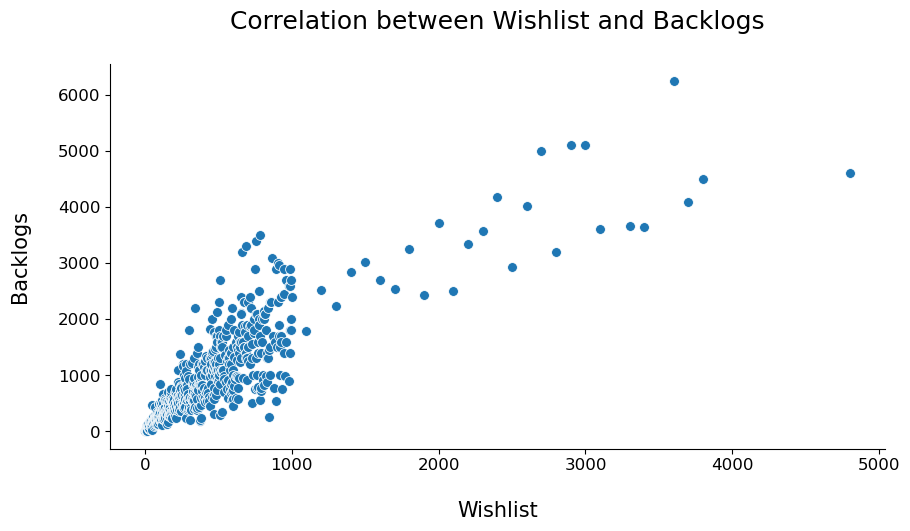

In [29]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.scatterplot(data=wishlist_backlog, x="Wishlist", y="Average Backlogs", s=50)

# Despine the plot from the right and top
sns.despine(ax=ax, top=True, right=True)

# Add a descriptive title and increase its size and add padding
ax.set_title("Correlation between Wishlist and Backlogs", fontsize=18, pad=25)

# Increase the size of the x-axis and y-axis ticks
ax.tick_params(axis="both", labelsize=12)

# Increase the size of the x-axis and y-axis labels and add paddings
ax.set_xlabel("Wishlist", fontsize=15, labelpad=20)
ax.set_ylabel("Backlogs", fontsize=15, labelpad=20)

# Show the plot
plt.show();

In [30]:
# Group data by the rating column and calculate the mean of the backlogs column for each group
rating_backlogs = df.groupby("Rating")["Backlogs"].mean().reset_index()

# Renaming the columns for clarity
rating_backlogs.columns = ["Rating", "Average Backlogs"]

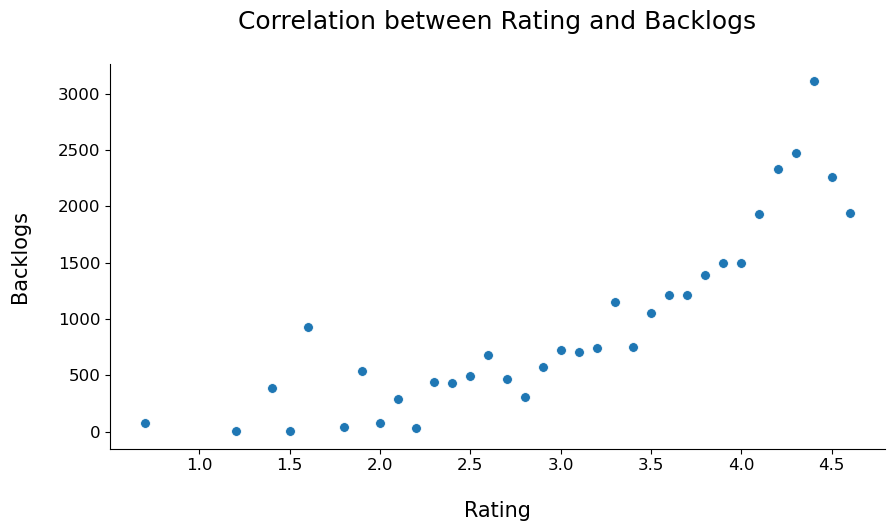

In [31]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Plot scatterplot
ax = sns.scatterplot(data=rating_backlogs, x="Rating", y="Average Backlogs", s=50)

# Despine the plot from the right and top
sns.despine(ax=ax, top=True, right=True)

# Add title and increase its size and add padding
ax.set_title("Correlation between Rating and Backlogs", fontsize=18, pad=25)

# Increase the size of the x-axis and y-axis ticks
ax.tick_params(axis="both", labelsize=12)

# Increase the size of the x-axis and y-axis labels and add paddings
ax.set_xlabel("Rating", fontsize=15, labelpad=20)
ax.set_ylabel("Backlogs", fontsize=15, labelpad=20)

plt.show();

#### Target Variable

In [32]:
df['Rating'].unique()

array([4.5, 4.3, 4.4, 4.2, 3. , 3.7, 4.1, 3.8, 3.3, 4.6, 2.6, 3.9, 4. ,
       2.7, 3.6, 3.5, 3.2, 2.8, 2.1, 3.4, 3.1, 2.9, 2.5, 1.9, 2.4, 2.3,
       1.2, 2.2, 1.6, 1.5, 2. , 1.4, 0.7, 1.8])

In [33]:
df['Rating'].describe()

count    1496.000000
mean        3.718917
std         0.531543
min         0.700000
25%         3.400000
50%         3.800000
75%         4.100000
max         4.600000
Name: Rating, dtype: float64

In [34]:
def sentiment_rating(rating):
    # Replacing ratings of 4,5 with 1 (good) and 1,2 with 0 (not good)
    if(float(rating) < 3):
        return 0
    else: 
        return 1

df['Rating Status'] = df['Rating'].apply(sentiment_rating) 
df.sample(2)

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year,Rating Status
521,Rain World,"['Videocult', 'Adult Swim Games']",4.1,411,"['Adventure', 'Indie', 'Platform', 'RPG']",Rain World is a survival platformer set in an ...,"['muito bom quase perfeito, mas a dificuldade ...",1100,170,1400,987,2017,1
1285,Mega Man X5,"['Capcom Production Studio 3', 'Capcom']",3.2,334,"['Adventure', 'Platform', 'Shooter']",Mega Man returns for more wild action in MEGA ...,"['Como que isso veio depois de X4?', 'Tem prob...",2200,11,450,126,2000,1


In [35]:
Good_Reviews = df[df['Rating Status'] == 1]
Bad_Reviews = df[df['Rating Status'] == 0]

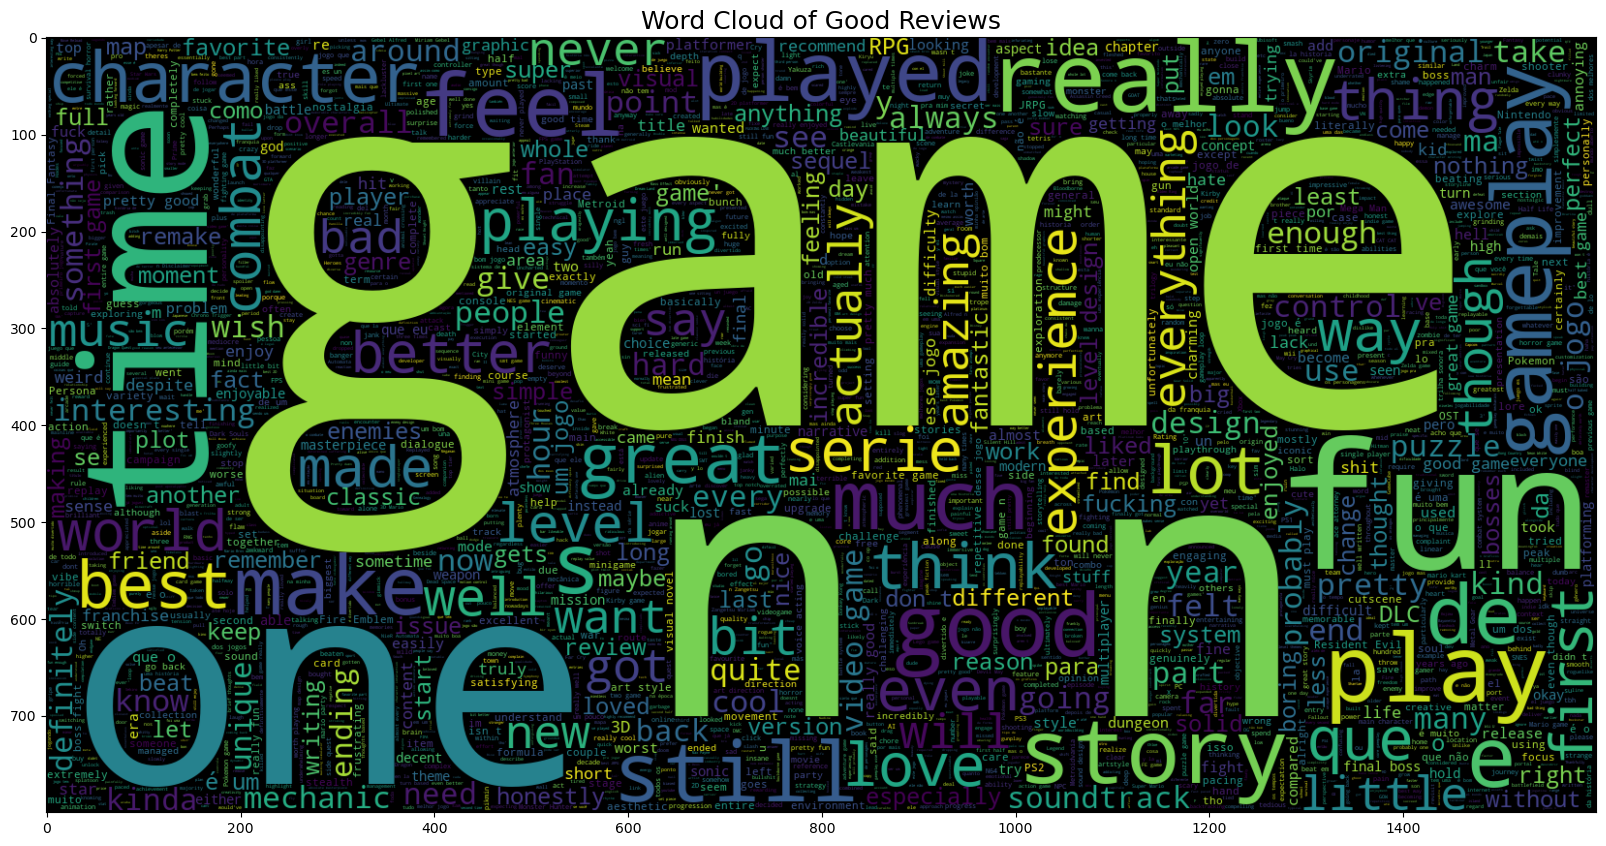

In [36]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) # Text Reviews with High Ratings
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(Good_Reviews['Reviews']))
plt.title("Word Cloud of Good Reviews", fontsize = 18)
plt.imshow(wc,interpolation = 'bilinear')

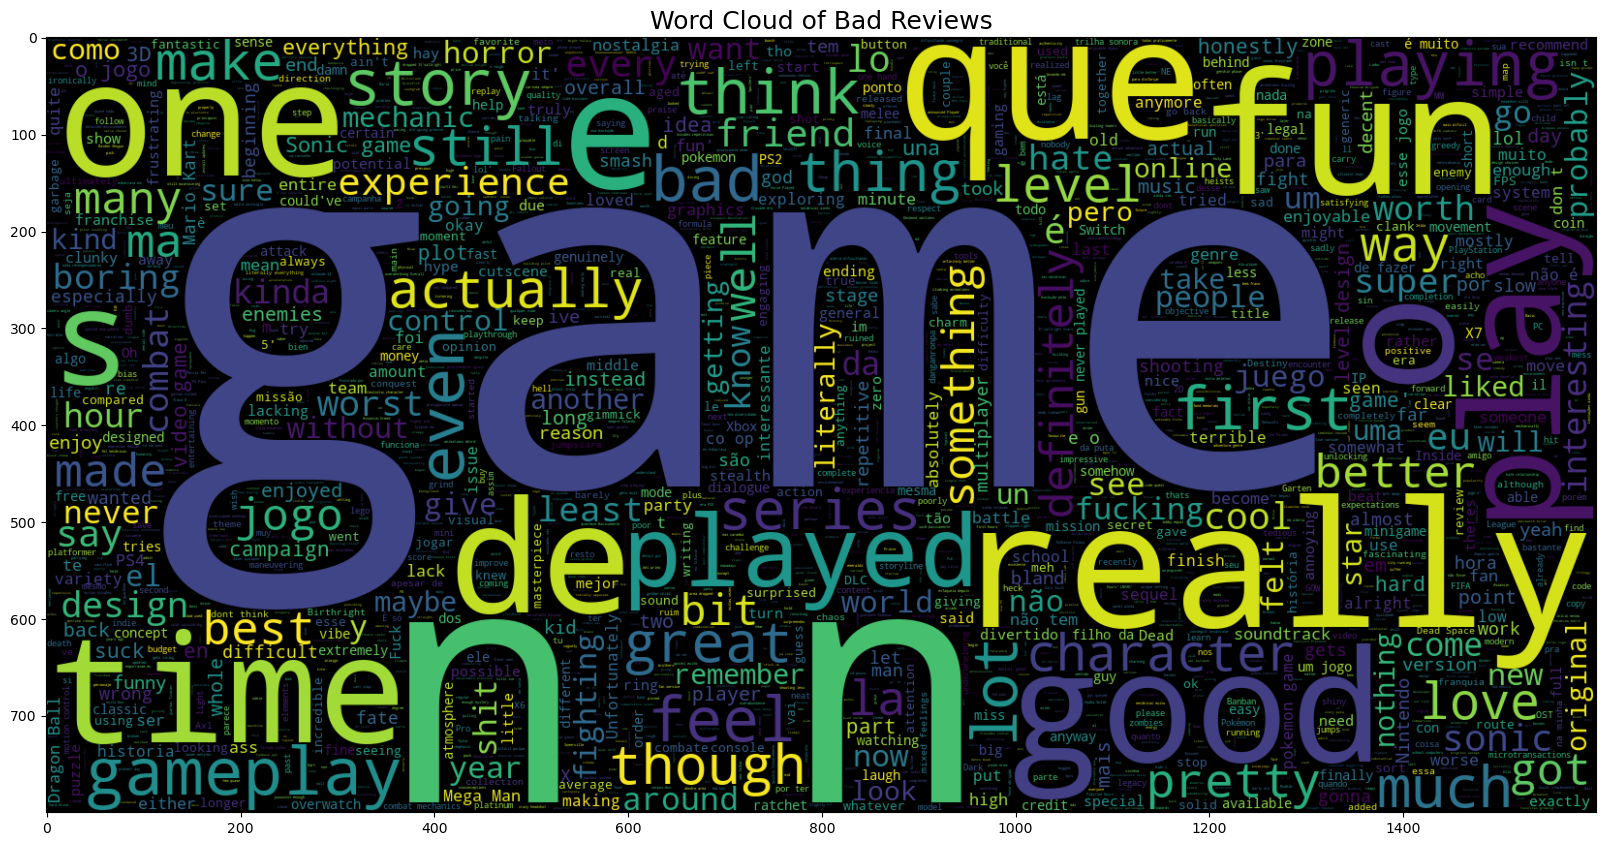

In [37]:
plt.figure(figsize = (20,20)) # Text Reviews with Poor Ratings
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(Bad_Reviews['Reviews']))
plt.title("Word Cloud of Bad Reviews", fontsize = 18)
plt.imshow(wc,interpolation = 'bilinear')

### Natural Language Processing

In [38]:
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [39]:
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df['Reviews'][3])

['soundtrack tied #1 nier automata. super charming story characters become iconic. made 1 man. thats it, thats review criticisms', 'Just play game, Dont look reviews, pick game know nothing else one lucky ones didnt get spoiled game. It fucking break best ways', 'Não há palavras que deem para descrever experiência que foi esse jogo.', 'CLASSSSSSSSSSSSSSSICCCCCCCCCCCCCCCCCCC', 'whooaa ohh ohhhh ohoohhohh ohhwooaah story undertale', 'A nice unique take RPG indie game format incorporating really good ideas, funny interactions, incredibly subtle story, wonderful music. Definitely must play already.']


In [89]:
#!pip install langdetect
from langdetect import detect

# Assuming your dataframe is called 'df' and the comments are in a column named 'comment'
# Create a new column to store the language detection results
df['language'] = ""

# Iterate over each comment and detect the language
for i, comment in enumerate(df['Reviews']):
    try:
        language = detect(comment)
        df.at[i, 'language'] = language
    except:
        df.at[i, 'language'] = "unknown"

df.sample(5)

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year,Rating Status,language
781,Minecraft,['Mojang Studios'],4.3,2300.0,"['Adventure', 'Simulator']",Minecraft focuses on allowing the player to ex...,['Minecraft make it. Unfortunately theres reas...,33000.0,1800.0,1100.0,230.0,2011.0,1.0,en
641,Nioh 2,"['Koei Tecmo Games', 'Team NINJA']",4.0,365.0,"['Adventure', 'Brawler', 'RPG']",Master the lethal arts of the samurai as a mys...,"['Esse jogo não é difícil como dizem, só é des...",1400.0,150.0,1100.0,580.0,2020.0,1.0,en
1422,Worms Armageddon,"['Team17', 'Infogrames Europe']",3.8,180.0,"['Platform', 'Shooter', 'Strategy']",Those intrepid invertebrates return with a ven...,"[""I'm dead meat!"", ""Web 2.0 - lookin' UI."", ""I...",2100.0,15.0,150.0,57.0,1999.0,1.0,
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en
1233,The Witcher 3: Wild Hunt - Hearts of Stone,['CD Projekt RED'],4.4,159.0,"['Adventure', 'RPG']","Step again into the shoes of Geralt of Rivia, ...","['shani casa-te comigo por favor', 'Some horri...",3100.0,39.0,487.0,106.0,2015.0,1.0,en


In [42]:
# Filter the dataframe to keep only English comments
df = df[df['language'] == 'en']

# Remove the language column if it's no longer needed
df.drop('language', axis=1, inplace=True)

df.head()

,Title,Team,Rating,Number of Reviews,Genres,Summary,Reviews,Number of Plays,Active Players,Backlogs,Wishlist,Release Year,Rating Status
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900.0,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough elden ring one best ep...",17000.0,3800.0,4600.0,4800.0,2022.0,1.0
1,Hades,['Supergiant Games'],4.3,2900.0,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced roguelike people like genre. The a...,21000.0,3200.0,6300.0,3600.0,2019.0,1.0
3,Undertale,"['tobyfox', '8-4']",4.2,3500.0,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack tied #1 nier automata. super char...,28000.0,679.0,4900.0,1800.0,2015.0,1.0
4,Hollow Knight,['Team Cherry'],4.4,3000.0,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding incredible, amazing...",21000.0,2400.0,8300.0,2300.0,2017.0,1.0
6,Omori,"['OMOCAT', 'PLAYISM']",4.2,1600.0,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",A turn-based surreal horror RPG in which a chi...,"[""The best game I've played life"", ""omori game...",7200.0,1100.0,4500.0,3800.0,2020.0,1.0


In [43]:
# Drop rows with NaN values
df = df.dropna(subset=['Reviews'])

In [44]:
# Create dataframe specific to reviews only
reviews_df = df[['Title','Reviews']]
reviews_df.head()

,Title,Reviews
0,Elden Ring,"[""The first playthrough elden ring one best ep..."
1,Hades,['convinced roguelike people like genre. The a...
3,Undertale,['soundtrack tied #1 nier automata. super char...
4,Hollow Knight,"[""this games worldbuilding incredible, amazing..."
6,Omori,"[""The best game I've played life"", ""omori game..."


#### Apply the term frequency–inverse document frequency method to reviews

In [45]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(reviews_df['Reviews'])

# Print the TF-IDF matrix
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
# Print the feature names
print(vectorizer.get_feature_names_out())

['000' '007' '00s' ... 'والثانيه' '茶番だ' '𝗦𝗛𝗜𝗧']


#### Apply Advance Tokenisation

In [48]:
# Create an instance of TweetTokenizer
tokenizer = TweetTokenizer()

# Create an instance of MWETokenizer
mwe_tokenizer = MWETokenizer()

# Get MWEs from WordNet
mwe_synsets = wordnet.synsets('collocation')
mwes = set()
for synset in mwe_synsets:
    mwes.update(synset.lemma_names())

# Add MWEs to the tokenizer
for mwe in mwes:
    mwe_tokens = tokenizer.tokenize(mwe.replace('_', ' '))
    mwe_tokenizer.add_mwe(mwe_tokens)

# Tokenize text from DataFrame column using the MWETokenizer
reviews_df['tokenized_text'] = reviews_df['Reviews'].apply(lambda x: mwe_tokenizer.tokenize(tokenizer.tokenize(x)))

print(reviews_df[['Reviews','tokenized_text']])

                                                Reviews  \
0     ["The first playthrough elden ring one best ep...   
1     ['convinced roguelike people like genre. The a...   
3     ['soundtrack tied #1 nier automata. super char...   
4     ["this games worldbuilding incredible, amazing...   
6     ["The best game I've played life", "omori game...   
...                                                 ...   
1491  ['all time gone.', "I can't learn game I dumb,...   
1492  ['Played part Sonic Gems Collection Gamecube.'...   
1493  ["It's game. It's guitar hero. If like guitar ...   
1494  ['i feel offended', "Every 5 years I give anot...   
1495  ["I'd rather nothing", 'Better nothing', "I fe...   

                                         tokenized_text  
0     [[, ", The, first, playthrough, elden, ring, o...  
1     [[, ', convinced, roguelike, people, like, gen...  
3     [[, ', soundtrack, tied, #, 1, nier, automata,...  
4     [[, ", this, games, worldbuilding, incredible,...  
6

#### Apply stemming

In [49]:
# Create a stemmer
stemmer = PorterStemmer()

# Apply stemming to the tokenized tweets
reviews_df['stemmed_text'] = reviews_df['tokenized_text'].apply(lambda x: [stemmer.stem(word) for word in x])

print(reviews_df[['Title', 'tokenized_text','stemmed_text']])

                        Title  \
0                  Elden Ring   
1                       Hades   
3                   Undertale   
4               Hollow Knight   
6                       Omori   
...                       ...   
1491    Europa Universalis IV   
1492     Sonic the Hedgehog 2   
1493            Guitar Hero 5   
1494  Silent Hill: Homecoming   
1495             Mighty No. 9   

                                         tokenized_text  \
0     [[, ", The, first, playthrough, elden, ring, o...   
1     [[, ', convinced, roguelike, people, like, gen...   
3     [[, ', soundtrack, tied, #, 1, nier, automata,...   
4     [[, ", this, games, worldbuilding, incredible,...   
6     [[, ", The, best, game, I've, played, life, ",...   
...                                                 ...   
1491  [[, ', all, time, gone, ., ', ,, ", I, can't, ...   
1492  [[, ', Played, part, Sonic, Gems, Collection, ...   
1493  [[, ", It's, game, ., It's, guitar, hero, ., I...   
1494  [[, ', 

#### Applying lemmatisation

In [55]:
# Load the English language model in spaCy
nlp = spacy.load("en_core_web_sm")

In [56]:
# Function to get the POS tag from NLTK's pos_tag and convert it to spaCy format
def get_spacy_pos(tag):
    if tag.startswith('J'):
        return 'ADJ'
    elif tag.startswith('V'):
        return 'VERB'
    elif tag.startswith('N'):
        return 'NOUN'
    elif tag.startswith('R'):
        return 'ADV'
    else:
        return ''

In [57]:
# Apply POS tagging to the text column using NLTK
reviews_df['pos_tags'] = reviews_df['stemmed_text'].apply(lambda x: pos_tag(x))

In [58]:
# Apply spaCy processing to the text column
reviews_df['lemmas_spacy'] = reviews_df['stemmed_text'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])

In [59]:
# Convert POS tags to spaCy format
reviews_df['pos_tags_spacy'] = reviews_df['pos_tags'].apply(lambda x: [(word, get_spacy_pos(tag)) for word, tag in x])

In [60]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the DataFrame column
reviews_df['lemmatized_words'] = reviews_df['stemmed_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Print the DataFrame with lemmatized words
print(reviews_df[['stemmed_text', 'pos_tags', 'lemmas_spacy', 'pos_tags_spacy', 'lemmatized_words']])

                                           stemmed_text  \
0     [[, ", the, first, playthrough, elden, ring, o...   
1     [[, ', convinc, roguelik, peopl, like, genr, ....   
3     [[, ', soundtrack, tie, #, 1, nier, automata, ...   
4     [[, ", thi, game, worldbuild, incred, ,, amaz,...   
6     [[, ", the, best, game, i'v, play, life, ", ,,...   
...                                                 ...   
1491  [[, ', all, time, gone, ., ', ,, ", i, can't, ...   
1492  [[, ', play, part, sonic, gem, collect, gamecu...   
1493  [[, ", it', game, ., it', guitar, hero, ., if,...   
1494  [[, ', i, feel, offend, ', ,, ", everi, 5, yea...   
1495  [[, ", i'd, rather, noth, ", ,, ', better, not...   

                                               pos_tags  \
0     [([, NN), (", VBZ), (the, DT), (first, JJ), (p...   
1     [([, NN), (', ''), (convinc, JJ), (roguelik, N...   
3     [([, NN), (', ''), (soundtrack, NN), (tie, NN)...   
4     [([, JJ), (", NNP), (thi, NN), (game, NN), (wo...

#### Apply Latent Dirichlet Allocation

In [61]:
# Extract the lemmatized column
lemmatized_documents = reviews_df['lemmatized_words']

# Convert the list of lemmatized documents to strings
lemmatized_documents = [' '.join(document) for document in lemmatized_documents]

In [62]:
# Create the CountVectorizer
vectorizer = CountVectorizer()

# Apply CountVectorizer to convert lemmatized text to token counts
X = vectorizer.fit_transform(lemmatized_documents)

In [63]:
# Create the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)

# Fit the LDA model to the token counts
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [65]:
# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

Topic 1: game, the, play, charact, realli
Topic 2: de, que, la, game, lo
Topic 3: game, it, play, the, like
Topic 4: de, que, jogo, um, não
Topic 5: game, play, like, realli, it
Topic 6: game, the, play, fun, one
Topic 7: game, fun, the, stori, end
Topic 8: game, the, time, it, good
Topic 9: game, play, like, it, the
Topic 10: game, play, the, it, one


### Data Modelling

Creating a dataframe specific to reviews.

In [66]:
# dataframe for model
model_df = df[['Title','Team','Genres','Summary','Reviews','Release Year','Rating','Rating Status']]
model_df.head()

,Title,Team,Genres,Summary,Reviews,Release Year,Rating,Rating Status
0,Elden Ring,"['Bandai Namco Entertainment', 'FromSoftware']","['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough elden ring one best ep...",2022.0,4.5,1.0
1,Hades,['Supergiant Games'],"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced roguelike people like genre. The a...,2019.0,4.3,1.0
3,Undertale,"['tobyfox', '8-4']","['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack tied #1 nier automata. super char...,2015.0,4.2,1.0
4,Hollow Knight,['Team Cherry'],"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding incredible, amazing...",2017.0,4.4,1.0
6,Omori,"['OMOCAT', 'PLAYISM']","['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",A turn-based surreal horror RPG in which a chi...,"[""The best game I've played life"", ""omori game...",2020.0,4.2,1.0


In [67]:
# Defining features
X = model_df['Reviews']
Y = model_df.iloc[:, -1]

In [68]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [69]:
# Define custom tokenizer function
def custom_tokenizer(text):
    tokens = word_tokenize(text)  # Tokenization
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens and convert to lowercase
    tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    stemmed_tokens = [PorterStemmer().stem(token) for token in tokens]  # Stemming
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in stemmed_tokens]  # Lemmatization
    return lemmatized_tokens

In [70]:
# Create the pipeline for Logistic Regression
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', LogisticRegression())
])

In [71]:
# Create the pipeline for KNN
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', KNeighborsClassifier())
])

In [72]:
# Create the pipeline for Naive Bayes
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', MultinomialNB())
])

In [73]:
# Create the pipeline for SVC
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', SVC())  # Replace with the classifier of your choice
])

In [74]:
# Create the pipeline for Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', RandomForestClassifier())
])

In [75]:
# Create the pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
    ('classification', XGBClassifier())
])

In [76]:
# List of pipelines
class_pipelines = [logreg_pipeline, knn_pipeline, nb_pipeline, svc_pipeline, rf_pipeline, xgb_pipeline]

In [77]:
# Fit and evaluate each pipeline
for pipeline in class_pipelines:
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    classifier_name = pipeline.named_steps['classification'].__class__.__name__
    print(f"{classifier_name} Accuracy: {accuracy}")
    print(f"{classifier_name} Classification Report:")
    print(classification_report(y_test, predictions))
    print("-------------------------------------------")

LogisticRegression Accuracy: 0.9073359073359073
LogisticRegression Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        24
         1.0       0.91      1.00      0.95       235

    accuracy                           0.91       259
   macro avg       0.45      0.50      0.48       259
weighted avg       0.82      0.91      0.86       259

-------------------------------------------
KNeighborsClassifier Accuracy: 0.9111969111969112
KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.04      0.08        24
         1.0       0.91      1.00      0.95       235

    accuracy                           0.91       259
   macro avg       0.96      0.52      0.52       259
weighted avg       0.92      0.91      0.87       259

-------------------------------------------
MultinomialNB Accuracy: 0.9073359073359073
MultinomialNB Classification Re

In [78]:
# Create pipelines for each method
method_pipelines = {
    'No Method': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classification', RandomForestClassifier())
    ]),
    'Tokenization': Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=word_tokenize)),
        ('classification', RandomForestClassifier())
    ]),
    'Stemming': Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
        ('classification', RandomForestClassifier())
    ]),
    'Lemmatization': Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
        ('classification', RandomForestClassifier())
    ])
}

In [79]:
# Fit and evaluate each pipeline
for method, pipeline in method_pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    classifier_name = pipeline.named_steps['classification'].__class__.__name__
    print(f"{method} - {classifier_name} Accuracy: {accuracy}")
    print(f"{method} - {classifier_name} Classification Report:")
    print(classification_report(y_test, predictions))
    print("-------------------------------------------")

No Method - RandomForestClassifier Accuracy: 0.9382239382239382
No Method - RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        24
         1.0       0.94      1.00      0.97       235

    accuracy                           0.94       259
   macro avg       0.97      0.67      0.73       259
weighted avg       0.94      0.94      0.92       259

-------------------------------------------
Tokenization - RandomForestClassifier Accuracy: 0.9382239382239382
Tokenization - RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        24
         1.0       0.94      1.00      0.97       235

    accuracy                           0.94       259
   macro avg       0.97      0.67      0.73       259
weighted avg       0.94      0.94      0.92       259

-------------------------------------------
Stemming

### Hyper Parameter Tuning

In [80]:
# Define the hyperparameters to tune
param_grid = {
    'tfidf__max_features': [500, 1000, 2000],
    'classification__n_estimators': [100, 200, 300],
    'classification__max_depth': [None, 5, 10]
}

In [81]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x00000188E4340360>)),
                                       ('classification',
                                        RandomForestClassifier())]),
             param_grid={'classification__max_depth': [None, 5, 10],
                         'classification__n_estimators': [100, 200, 300],
                         'tfidf__max_features': [500, 1000, 2000]})

In [82]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'classification__max_depth': None, 'classification__n_estimators': 100, 'tfidf__max_features': 1000}
Best Score: 0.9274095961727873


In [83]:
# Perform cross-validation on the outer pipeline
scores = cross_val_score(rf_pipeline, X, Y, cv=5)

In [84]:
# Print cross-validation scores
print("Cross-Validation Scores:")
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")

Cross-Validation Scores:
Fold 1: 0.9343629343629344
Fold 2: 0.9382239382239382
Fold 3: 0.9186046511627907
Fold 4: 0.9341085271317829
Fold 5: 0.9108527131782945


In [85]:
# Print the cross-validation scores mean
print("Mean Score:", scores.mean())

Mean Score: 0.9272305528119482


### Making Predictions

In [86]:
# method to determine prediction
def predictionSentiment(prediction):
    if prediction == 1:
        print('This review is positive.')
    else:
        print('This review is negative.')

In [87]:
# positive review
text = 'This game is amazing. Great storyline and pixel quality'

# predict
predictionSentiment(rf_pipeline.predict(pd.Series(text)))

This review is positive.
